<a href="https://colab.research.google.com/github/TheCaveOfAdullam/study3/blob/main/originalBaseModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

In [3]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_motor10'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']

# 데이터 로드 및 전처리 함수 정의
def load_data(base_dir, split):
    X = []
    y = []
    split_dir = os.path.join(base_dir, split)
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        for file in os.listdir(category_dir):
            file_path = os.path.join(category_dir, file)
            data = pd.read_csv(file_path, header=None).values
            data = pd.to_numeric(data.flatten(), errors='coerce').reshape(-1, data.shape[1])
            data = np.nan_to_num(data).astype('float32')  # NaN 값을 0으로 대체하고, float32로 변환
            X.append(data)
            y.append(category)
    return np.array(X), np.array(y)

# 데이터 로드
X_train, y_train = load_data(base_dir, 'train')
X_val, y_val = load_data(base_dir, 'validation')
X_test, y_test = load_data(base_dir, 'test')

# 데이터 차원 변경 (CNN 입력 형식에 맞게)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 레이블 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 원-핫 인코딩
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded)
y_val_categorical = tf.keras.utils.to_categorical(y_val_encoded)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded)

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 모델 정의
model = models.Sequential()

# Conv1 레이어
model.add(layers.Conv1D(filters=64, kernel_size=16, strides=16, activation='relu',
                        input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(layers.MaxPooling1D(pool_size=2, strides=2))

# Conv2 레이어
model.add(layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu'))

# Conv3 레이어
model.add(layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu'))

# Conv4 레이어
model.add(layers.Conv1D(filters=128, kernel_size=5, strides=1, activation='relu'))

model.add(layers.MaxPooling1D(pool_size=2, strides=2))

# Flatten 레이어
model.add(layers.Flatten())

# FC1 레이어
model.add(layers.Dense(units=5000, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  # L2 정규화 강도를 약간 증가 (0.001 -> 0.002)
model.add(layers.Dropout(0.3))  # 드롭아웃 비율을 약간 증가 (0.5 -> 0.55)

# FC2 레이어
model.add(layers.Dense(units=1000, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))  # L2 정규화 강도를 약간 증가 (0.001 -> 0.002)
model.add(layers.Dropout(0.3))  # 드롭아웃 비율을 약간 증가 (0.5 -> 0.55)

# Output 레이어
model.add(layers.Dense(len(categories), activation='softmax'))

# 아담 옵티마이저 학습률 조정
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, clipnorm=1.0)

# ReduceLROnPlateau 콜백 정의
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_148 (Conv1D)         (None, 750, 64)           2112      
                                                                 
 max_pooling1d_74 (MaxPooli  (None, 375, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_149 (Conv1D)         (None, 373, 32)           6176      
                                                                 
 conv1d_150 (Conv1D)         (None, 369, 64)           10304     
                                                                 
 conv1d_151 (Conv1D)         (None, 365, 128)          41088     
                                                                 
 max_pooling1d_75 (MaxPooli  (None, 182, 128)          0         
 ng1D)                                               

In [92]:
# 모델 훈련
history = model.fit(X_train, y_train_categorical,
                    epochs=10,
                    validation_data=(X_val, y_val_categorical),
                    batch_size=32,
                    callbacks=[reduce_lr])  # ReduceLROnPlateau 콜백 적용

Epoch 1/10
394/394 [==============================] - 269s 680ms/step - loss: 1.9054 - accuracy: 0.4998 - val_loss: 1.6529 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 2/10
394/394 [==============================] - 264s 670ms/step - loss: 1.3559 - accuracy: 0.5829 - val_loss: 0.9351 - val_accuracy: 0.6667 - lr: 2.0000e-05
Epoch 3/10
394/394 [==============================] - 267s 677ms/step - loss: 0.8399 - accuracy: 0.7432 - val_loss: 0.7415 - val_accuracy: 0.8333 - lr: 2.0000e-05
Epoch 4/10
394/394 [==============================] - 267s 678ms/step - loss: 0.6590 - accuracy: 0.7911 - val_loss: 0.4990 - val_accuracy: 0.8415 - lr: 2.0000e-05
Epoch 5/10
394/394 [==============================] - 269s 682ms/step - loss: 0.5336 - accuracy: 0.8388 - val_loss: 0.4579 - val_accuracy: 0.8826 - lr: 2.0000e-05
Epoch 6/10
394/394 [==============================] - 271s 687ms/step - loss: 0.4831 - accuracy: 0.8436 - val_loss: 0.4176 - val_accuracy: 0.8489 - lr: 2.0000e-05
Epoch 7/10
394/394 [==

In [93]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')

85/85 [==============================] - 4s 46ms/step - loss: 0.1860 - accuracy: 0.9830
Test accuracy: 0.982962965965271


In [94]:
# 모델 학습 결과 시각화 (선택 사항)
import matplotlib.pyplot as plt

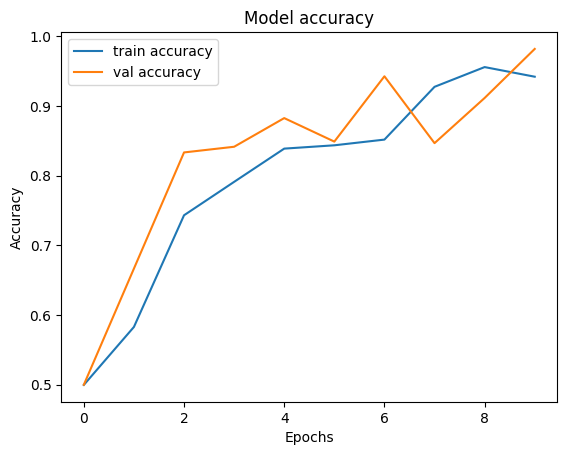

In [95]:
# 학습 및 검증 정확도
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

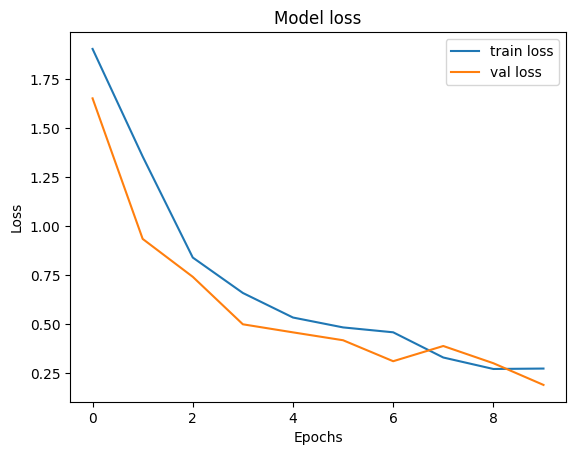

In [96]:
# 학습 및 검증 손실
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test accuracy: {test_accuracy}')

85/85 [==============================] - 4s 45ms/step - loss: 0.1860 - accuracy: 0.9830
Test accuracy: 0.982962965965271


In [98]:
# 원본 모델 저장
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [99]:
# 모델 사이즈 측정
model_size = os.path.getsize('model.h5') / (1024 * 1024)
print(f"Model Size: {model_size:.2f} MB")

Model Size: 1391.09 MB
